# GNN - Graph Neural Networks
### Before start
This Notebook is overview of GNN and torch geometric module.\
I used these resources in my preparation:
- https://youtu.be/-UjytpbqX4A - Graph Neural Networks (GNN) using Pytorch Geometric | Stanford University
- https://youtu.be/8owQBFAHw7E - Intro to graph neural networks (ML Tech Talks)
- https://pytorch-geometric.readthedocs.io/en/latest/ - Documentation on PyTorch Geometric\
\
Install PyTorch if not already.
Check CUDA version before install. See more: https://pytorch.org/get-started/locally/

In [1]:
try:
    import torch
except ImportError:
    !pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu124
    import torch

In [2]:
torch.__version__

'2.6.0+cu124'

It looks OK. Networkx is the most popular Python package for graph representation and some mathematical actions:

In [3]:
!pip install networkx

Let's show star graph example:

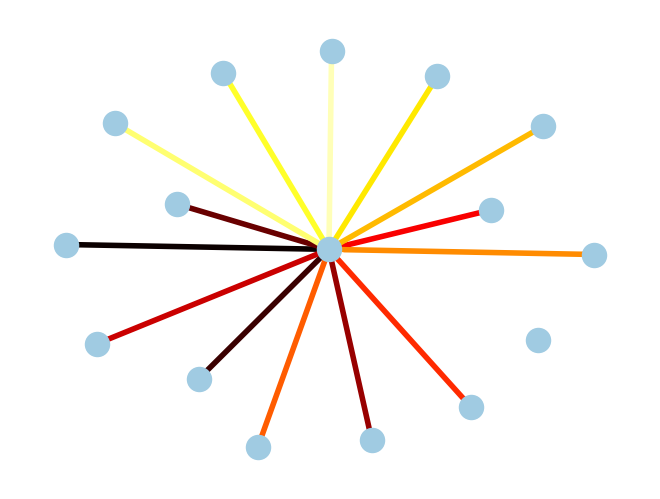

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

G = nx.star_graph(15)
pos = nx.spring_layout(G, seed=63)  # Seed layout for reproducibility
colors = range(15)
options = {
    "node_color": "#A0CBE2",
    "edge_color": colors,
    "width": 4,
    "edge_cmap": plt.cm.hot,
    "with_labels": False,
}
nx.draw(G, pos, **options)

You can also get adjacency matrix of graph or something else:

In [5]:
A = nx.adjacency_matrix(G)
A

<16x16 sparse array of type '<class 'numpy.int64'>'
	with 30 stored elements in Compressed Sparse Row format>

In [6]:
A.toarray()

array([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [7]:
A.shape

(16, 16)

In [8]:
nx.degree(G)

DegreeView({0: 15, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1})

Learn more: https://networkx.org/documentation/stable/reference/functions.html

torch_geometric is module for GNN implementations in PyTorch

In [9]:
try:
    import torch_geometric
except ImportError:
    !pip install torch_geometric
    import torch_geometric

/home/dolgikh/anaconda3/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /home/dolgikh/anaconda3/lib/python3.12/site-packages/libpyg.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/dolgikh/anaconda3/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/dolgikh/anaconda3/lib/python3.12/site-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_St8optionalIN3c1017basic_string_viewIcEEE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/dolgikh/anaconda3/lib/python3.12/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktra

Add some helpful modules for memory efficiency. It is not necessary, but recommended. Check CUDA version before install, it should be same with PyTorch.

In [10]:
try:
    import torch.sparse
except ImportError:
    !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cu124.html

### Data preprocessing

I will use prepared by Ivan Kharuk the data loader with some modifications (add space edges). Provided file contains information about triggered detectors and reconstructed logarithm of energy:\
Input:
- Its x, y, z coordinates (spatial position)
- Integral registered charge (energy deposited)
- Time of the plane from arrival (obtained from the reconstruction procedure)
- Time difference between plane front arrival and actual activation (helps to analyze wavefront curvature)
  
Output: Logarithm of energy.\
\
All features was normalized to distribution with mean=0 and std=1.
\
See https://github.com/TA-DNN/TAML2025_ICRR_handson/blob/main/day2/hands-on_transformers/transformer_encoder_excercise.ipynb for more comments.\
Graph constructing algorithm:\
Let detectors will be vertexes of the graph. Edges connect two vertexes if detetors is neibhours in 2D plate and/or neibhours in time sorted array.

In [11]:
import torch
from torch.utils.data import IterableDataset, DataLoader
import numpy as np
import h5py as h5

class DatasetGenerator(IterableDataset):

    def __init__(self, file, regime, batch_size, return_reminder,
                 num_time_neighbours,
                 num_space_neighbours,
                 apply_add_gauss, gauss_stds,
                 apply_mult_gauss, mult_gauss_std
                 ):
        self.file = file
        self.regime = regime
        self.batch_size = batch_size
        self.num_time_neighbours = num_time_neighbours
        self.num_space_neighbours = num_space_neighbours
        self.apply_add_gauss = apply_add_gauss
        self.apply_mult_gauss = apply_mult_gauss
        self.g_mult_stds = mult_gauss_std

        with h5.File(self.file,'r') as hf:
            mean = hf['norm_param/dt_params/mean'][3]
            std = hf['norm_param/dt_params/std'][3]
            self.num = hf[self.regime+'/ev_starts'].shape[0]-1
        if apply_add_gauss:
            self.guass_add_stds = gauss_stds / std
        if apply_mult_gauss:
            self.Q_mean_noise = mean / std
            self.n_fraction = mult_gauss_std

        batch_num = self.num // self.batch_size
        self.stop = self.num if return_reminder else self.batch_size * batch_num

    def add_gauss(self, data):
        noise = np.random.normal(scale=self.guass_add_stds, size=data.shape)
        data += noise
        return data

    def mult_gauss(self, Qs):
        noises = np.random.normal(scale=self.n_fraction, size=Qs.shape)
        return Qs + noises * (Qs + self.Q_mean_noise)

    def step(self, hf, start_ev, stop_ev, start_det, stop_det):
        # read data
        dt_params = hf[self.regime+'/dt_params'][start_det:stop_det]
        # make labels
        energy_labels = np.log10(hf[self.regime+'/mc_params/'][start_ev:stop_ev,3:4])
        # apply additive noise
        if self.apply_add_gauss:
            dt_params = self.add_gauss(dt_params)
        # apply multiplicative noise
        if self.apply_mult_gauss:
            dt_params[...,3] = self.mult_gauss(dt_params[...,3])
        return dt_params, energy_labels

    def __iter__(self):
        # Initialize multiple workers
        # Get worker information
        worker_info = torch.utils.data.get_worker_info()
        # Determine the range of data this worker should process
        if worker_info is None:  # single-process data loading
            worker_start = 0
            worker_end = self.stop
        else:  # in a worker process
            # Split workload 
            per_worker = int(np.ceil(self.stop / float(worker_info.num_workers)))
            worker_id = worker_info.id
            
            worker_start = worker_id * per_worker
            worker_end = min(worker_start + per_worker, self.stop)
            
            # Adjust to batch boundaries
            worker_start = (worker_start // self.batch_size) * self.batch_size
            worker_end = min(((worker_end + self.batch_size - 1) // self.batch_size) * self.batch_size, self.stop)
        
        # Open the HDF5 file within __iter__ so that each worker gets its own handle.
        with h5.File(self.file, 'r') as hf:
            start_ev = worker_start
            
            iterate = True
            while iterate:
                stop_ev = start_ev + self.batch_size
                
                # Check if we've reached the end of this worker's range
                if stop_ev > worker_end:
                    # For training, make infinite dataset
                    if self.regime == 'train':
                        # Reset back to the start of this worker's range
                        start_ev = worker_start
                        stop_ev = start_ev + self.batch_size
                    else:
                        iterate = False
                        break
                
                # Read first and last detectors
                ev_idxs = hf[self.regime+'/ev_starts'][start_ev:stop_ev+1]
                dt_params, labels = self.step(hf, start_ev, stop_ev, ev_idxs[0], ev_idxs[-1])

                loc_ev_idxs = ev_idxs - ev_idxs[0]
                indices = np.arange(loc_ev_idxs[-1])
                # Compute all neighbor offsets at once: [-num_neighbours, ..., 0, ..., +num_neighbours]
                offsets = np.arange(-self.num_time_neighbours, self.num_time_neighbours + 1)
                # Compute neighbor indices
                neighbors = indices[:, None] + offsets[None, :]  # shape: (total_hits, 2*num_neighbours+1)
                # For each event, valid indices lie in [start, end)
                for start, end in zip(loc_ev_idxs[:-1], loc_ev_idxs[1:]):
                    invalid = (neighbors[start:end] < start) | (neighbors[start:end] >= end)
                    neighbors[start:end][invalid] = -1  # mark out-of-bound neighbors

                # Build COO format: rows are repeated for each neighbor and we filter invalid entries.
                rows_coo = np.repeat(indices, offsets.size)
                cols_coo = neighbors.flatten()
                mask = cols_coo >= 0
                edge_idxs = np.vstack((rows_coo[mask], cols_coo[mask]))

                # Make batch indices
                batch_idxs = np.repeat(np.arange(labels.shape[0]), np.diff(loc_ev_idxs))
                # Add space neibhours
                for sample_id in range(labels.shape[0]):
                    sample = dt_params[batch_idxs==sample_id]
                    offset = np.where(batch_idxs==sample_id)[0][0]
                    for v_ind,vertex in enumerate(sample):
                        XY = vertex[:2]
                        distances = ((sample[:,:2]-XY)**2).sum(axis=1) # Euclidian distance on XY lattice
                        distances_sort = distances.copy()
                        distances_sort.sort()
                        space_edges_mask = (distances > 0) & (distances <= distances_sort[self.num_space_neighbours])
                        space_edges = np.vstack((
                                                 np.arange(len(sample))[space_edges_mask]+offset,
                                                 np.repeat(v_ind+offset,sum(space_edges_mask))
                        ))
                        edge_idxs = np.hstack((edge_idxs,space_edges))
                edge_idxs = np.unique(edge_idxs, axis=1)
                start_ev += self.batch_size

                yield torch.from_numpy(dt_params).float(), torch.from_numpy(labels).float(), torch.from_numpy(edge_idxs), torch.from_numpy(batch_idxs)

def make_datasets(file, batch_size, num_time_neighbours, num_space_neighbours,
                 apply_add_gauss, gauss_stds,
                 apply_mult_gauss, mult_gauss_std):

    train_generator = DatasetGenerator(file, 'train', batch_size, False, num_time_neighbours, num_space_neighbours,
                 apply_add_gauss, gauss_stds,
                 apply_mult_gauss, mult_gauss_std)
    test_generator = DatasetGenerator(file, 'test', batch_size, False, num_time_neighbours, num_space_neighbours,
                 False, None,
                 False, None)

    train_dataset = DataLoader(train_generator, batch_size=None, shuffle=False, pin_memory=True, num_workers=4, prefetch_factor=4)
    test_dataset = DataLoader(test_generator, batch_size=None, shuffle=False, pin_memory=True, num_workers=2, prefetch_factor=3)

    return train_dataset, test_dataset


In [12]:
generator_config = {
  'file': '../../../taml2025_data/taml_0325_energy.h5',
  'batch_size': 64,
  'apply_add_gauss': True,
  'gauss_stds': [0., 0., 0., 0., 0. , 0.],
  'apply_mult_gauss': True,
  'mult_gauss_std': 0.1,
  'num_time_neighbours': 1,
  'num_space_neighbours': 4,
}

train_dataset_g, test_dataset_g = make_datasets(**generator_config)

Let's look on data format:

In [13]:
for ig in train_dataset_g:
    break

In [14]:
data, labels, edge_idxs, batch_idxs = ig

In [15]:
data.shape

torch.Size([1405, 6])

In [16]:
edge_idxs.shape

torch.Size([2, 8558])

In [17]:
edge_idxs[:,:15]

tensor([[0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2],
        [0, 1, 2, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 6]])

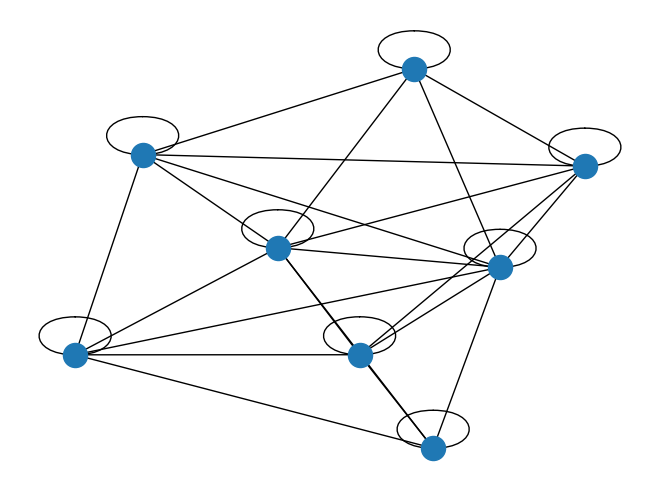

In [18]:
gr = nx.Graph()
gr.add_edges_from(edge_idxs.T.numpy()[:42])
nx.draw(gr)

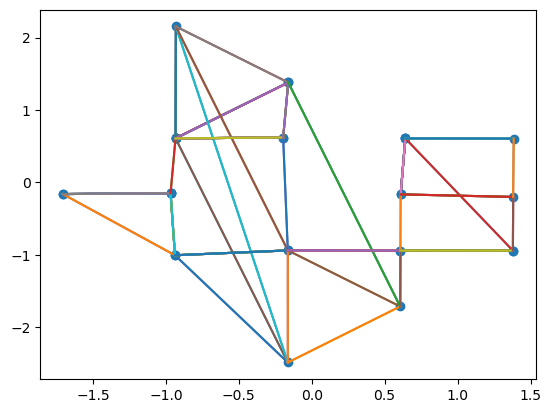

In [19]:
bi = 1
plt.scatter(data[batch_idxs==bi][:,0],data[batch_idxs==bi][:,1])
for edge in edge_idxs.T:
    if batch_idxs[edge[0]]==bi:
        plt.plot(data[edge,0],data[edge,1])

In [20]:
batch_idxs[:50]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2])

In [21]:
data[batch_idxs==0]

tensor([[ 0.5414, -1.5941, -1.2051, -0.4943, -0.5042, -0.3481],
        [ 0.5461, -0.8243, -1.1074, -0.4964, -0.2328, -0.7657],
        [-0.1986, -0.7951, -1.0037, -0.4666, -0.0465, -0.6553],
        [ 0.5435, -0.0488, -1.0852, -0.0198,  0.0443, -0.8896],
        [ 0.5435, -0.0488, -1.0852, -0.0270,  0.0443,  0.3297],
        [ 0.5442,  0.7246, -0.9282, -0.4954,  0.3160, -0.7222],
        [-0.9999, -0.0454, -1.0370, -0.4404,  0.4144, -0.9027],
        [-0.2268,  0.7237, -0.8708, -0.4101,  0.4993, -0.7661]])

### Creating and training GNN

Let's make a Graph Neural Network!

In [22]:
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

See more:\
GCNConv https://pytorch-geometric.readthedocs.io/en/2.6.0/generated/torch_geometric.nn.conv.GCNConv.html
global_mean_pool https://pytorch-geometric.readthedocs.io/en/2.6.0/generated/torch_geometric.nn.pool.global_mean_pool.html

In [23]:
gconv = GCNConv(6,16)
res = gconv(data,edge_idxs)
data.shape,res.shape

(torch.Size([1405, 6]), torch.Size([1405, 16]))

`GCNConv` works like convolutional layers for CNN `Conv2d` layer with `kernel_size=3` but don't remove vertexes (pixels) from layer to layer

In [24]:
res = global_mean_pool(res,batch_idxs)
res.shape

torch.Size([64, 16])

In [25]:
class MyGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(6, 32) # x,y,z,Q,t,t_act
        self.conv2 = GCNConv(32, 64)
        self.conv3 = GCNConv(64, 64) # What if change GCNConv to something else ?
        self.conv4 = GCNConv(64, 128)
        self.full_conn = nn.Sequential(nn.Linear(128,32),
                                       nn.LeakyReLU(),
                                       nn.Linear(32,16),
                                       nn.Tanh(),
                                       nn.Linear(16,1))

    def forward(self, x, edges, batch_idxs):
        x = self.conv1(x, edges)
        x = F.leaky_relu(x)
        x = self.conv2(x, edges)
        x = F.leaky_relu(x)
        x = self.conv3(x, edges)
        x = F.leaky_relu(x)
        x = self.conv4(x, edges)
        x = F.leaky_relu(x)
        x = global_mean_pool(x,batch_idxs) # What if change global_mean_pool -> global_max_pool ?
        x = self.full_conn(x)
        return x

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [27]:
model = MyGNN().to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
print("Num of params:",pytorch_total_params)

Num of params: 19489


In [28]:
res = model(data.to(device),edge_idxs.to(device),batch_idxs.to(device))
res.shape

torch.Size([64, 1])

In [29]:
def training_procedure(model, optimizer, train_dataset_g, test_dataset_g, epoch_size = 1000, stop_epoch = 20):
    train_mse = []
    test_mse = []
    for step,batch in enumerate(train_dataset_g):
        data, labels, edge_idxs, batch_idxs = [b.to(device) for b in batch]
        # Train step
        optimizer.zero_grad()
        y_pred = model(data,edge_idxs,batch_idxs)
        mse = F.mse_loss(y_pred, labels)
        mse.backward()
        optimizer.step()
        train_mse.append(mse.item())
        if step%epoch_size==0:
            with torch.no_grad():
                for test_step, test_batch in enumerate(test_dataset_g):
                    if test_step >= epoch_size:
                        break
                    data, labels, edge_idxs, batch_idxs = [b.to(device) for b in test_batch]
                    y_pred = model(data,edge_idxs,batch_idxs)
                    mse = F.mse_loss(y_pred, labels)
                    test_mse.append( mse.item() )
            print("Step:",int(step/epoch_size),
                  "Train loss:",sum(train_mse[-epoch_size:])/min(epoch_size,len(train_mse)),
                  "Test mse:",sum(test_mse[-epoch_size:])/epoch_size)
        if step/epoch_size >= stop_epoch:break
    return train_mse,test_mse

In [30]:
train_mse,test_mse = training_procedure(model, optimizer, train_dataset_g, test_dataset_g, epoch_size = 1000, stop_epoch = 25)

Step: 0 Train loss: 3.074141025543213 Test mse: 3.041857350349426
Step: 1 Train loss: 0.12177875927649438 Test mse: 0.034137616166844964
Step: 2 Train loss: 0.03306620113737881 Test mse: 0.031779802598059174
Step: 3 Train loss: 0.03117070926260203 Test mse: 0.030604489943943918
Step: 4 Train loss: 0.02994634304381907 Test mse: 0.0306929081492126
Step: 5 Train loss: 0.02894490113668144 Test mse: 0.029919615057297053
Step: 6 Train loss: 0.02876237036846578 Test mse: 0.02816325705125928
Step: 7 Train loss: 0.02795972592290491 Test mse: 0.027674796768464148
Step: 8 Train loss: 0.02721516116242856 Test mse: 0.026484642936848105
Step: 9 Train loss: 0.02685761992260814 Test mse: 0.025977850182913244
Step: 10 Train loss: 0.02607193031720817 Test mse: 0.025432436656206845
Step: 11 Train loss: 0.02591640560235828 Test mse: 0.024886127267964183
Step: 12 Train loss: 0.025617117430083453 Test mse: 0.025941039714962245
Step: 13 Train loss: 0.02555643925536424 Test mse: 0.02563432787451893
Step: 14 T

KeyboardInterrupt: 

Not bad, but not really good. Probably, we can improve results by using something from this stuff?\
https://pytorch-geometric.readthedocs.io/en/2.6.0/modules/nn.html

Let's create our own Message Passing layer

In [31]:
from torch_geometric.nn import MessagePassing

See more: https://pytorch-geometric.readthedocs.io/en/2.6.0/generated/torch_geometric.nn.conv.MessagePassing.html

In [32]:
class MyGraphLayer(MessagePassing):
    def __init__(self, in_channels, hidden_channels, out_channels, aggr = 'mean'):
        super(MyGraphLayer, self).__init__(aggr=aggr)
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.messageEncoder = nn.Sequential(nn.Linear(2*in_channels,hidden_channels),
                                            nn.LeakyReLU(),
                                            nn.Linear(hidden_channels,out_channels),
                                            nn.LeakyReLU())
        self.newVertexEncoder = nn.Linear(in_channels+out_channels,out_channels)
    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)
    def message(self, x_i, x_j):
        # x_i : "cental" node; x_j : neighbours
        # Make source-target dependent message
        msg = torch.cat([x_i, x_j], dim=-1) # concatenate embeddings like EdgeConv
        msg = self.messageEncoder(msg)
        return msg
    def update(self, aggr_out, x):
        embedding = torch.cat([aggr_out, x], dim=-1) # How to mix information from current vertex and neibhours?
        embedding = self.newVertexEncoder(embedding) # Let nn.Linear think about it
        return embedding

**Note**: Of coarse this idea has been implemented in torch_geometric (see https://pytorch-geometric.readthedocs.io/en/2.6.0/generated/torch_geometric.nn.conv.EdgeConv.html for example). This cell is an example of creating custom Message Passing mechanism.

In [33]:
l = MyGraphLayer(6,8,8)
test_output = l(data.cpu(),edge_idxs.cpu())
data.shape, test_output.shape

(torch.Size([1405, 6]), torch.Size([1405, 8]))

In [34]:
class MyGNN2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = MyGraphLayer(6,8,16) # x,y,z,Q,t,t_act
        self.conv2 = MyGraphLayer(16,32,32)
        self.conv3 = MyGraphLayer(32,32,32)
        self.conv4 = MyGraphLayer(32,32,64)
        self.full_conn = nn.Sequential(nn.Linear(64,32),
                                       nn.LeakyReLU(),
                                       nn.Linear(32,16),
                                       nn.Tanh(),
                                       nn.Linear(16,1))

    def forward(self, x, edges, batch_idxs):
        x = self.conv1(x, edges)
        x = F.leaky_relu(x)
        x = self.conv2(x, edges)
        x = F.leaky_relu(x)
        x = self.conv3(x, edges)
        x = F.leaky_relu(x)
        x = self.conv4(x, edges)
        x = F.leaky_relu(x)
        x = global_mean_pool(x,batch_idxs) # What if change global_mean_pool -> global_max_pool ?
        x = self.full_conn(x)
        return x

In [35]:
model = MyGNN2().to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)
print("Num of params:",pytorch_total_params)

Num of params: 22537


In [36]:
train_mse,test_mse = training_procedure(model, optimizer, train_dataset_g, test_dataset_g, epoch_size = 1000, stop_epoch = 25)

Step: 0 Train loss: 3.1625900268554688 Test mse: 3.1509586861133574
Step: 1 Train loss: 0.19627109128329903 Test mse: 0.022382126591168346
Step: 2 Train loss: 0.01931660778541118 Test mse: 0.01772455776669085
Step: 3 Train loss: 0.015103462073951959 Test mse: 0.01439873831300065
Step: 4 Train loss: 0.01315615003509447 Test mse: 0.013667547387070954
Step: 5 Train loss: 0.012219405790790916 Test mse: 0.011376915634609758
Step: 6 Train loss: 0.011537014064379037 Test mse: 0.014235421236604453
Step: 7 Train loss: 0.011331132009159774 Test mse: 0.012722090536728502
Step: 8 Train loss: 0.011120572333224117 Test mse: 0.010917655438650399
Step: 9 Train loss: 0.010811914251185953 Test mse: 0.010032518815249204
Step: 10 Train loss: 0.010538474227767438 Test mse: 0.010864920595195145


Much better! What we can change else? Aggregation is 'mean' in all below examples but could be more complex and contains learnable parameters:\
https://pytorch-geometric.readthedocs.io/en/2.6.0/generated/torch_geometric.nn.aggr.Aggregation.html \
\
Let's try AttentionalAggregation: https://pytorch-geometric.readthedocs.io/en/2.6.0/generated/torch_geometric.nn.aggr.AttentionalAggregation.html

AttentionalAggregation allows to summarize messages from neibhours with custom weights which calculates by small neural network. After calcuation weights normalizes by SoftMax function. AttentionalAggregation reduces to mean aggregation if the attential neural network will answer same value for every message.

In [37]:
from torch_geometric.nn import AttentionalAggregation

In [38]:
class MyGNN3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        aggrGate = nn.Linear(16,1) # Message size -> 1
        self.conv1 = MyGraphLayer(6,8,16, aggr = AttentionalAggregation(aggrGate))
        aggrGate = nn.Linear(32,1) # Message size -> 1
        self.conv2 = MyGraphLayer(16,32,32, aggr = AttentionalAggregation(aggrGate))
        aggrGate = nn.Linear(32,1) # Message size -> 1
        self.conv3 = MyGraphLayer(32,32,32, aggr = AttentionalAggregation(aggrGate))
        aggrGate = nn.Linear(64,1) # Message size -> 1
        self.conv4 = MyGraphLayer(32,32,64, aggr = AttentionalAggregation(aggrGate))
        self.full_conn = nn.Sequential(nn.Linear(64,32),
                                       nn.LeakyReLU(),
                                       nn.Linear(32,16),
                                       nn.Tanh(),
                                       nn.Linear(16,1))

    def forward(self, x, edges, batch_idxs):
        x = self.conv1(x, edges)
        x = F.leaky_relu(x)
        x = self.conv2(x, edges)
        x = F.leaky_relu(x)
        x = self.conv3(x, edges)
        x = F.leaky_relu(x)
        x = self.conv4(x, edges)
        x = F.leaky_relu(x)
        x = global_mean_pool(x,batch_idxs) # What if change global_mean_pool -> global_max_pool ?
        x = self.full_conn(x)
        return x

In [39]:
model = MyGNN3().to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=5e-4)
print("Num of params:",pytorch_total_params)

Num of params: 22685


In [40]:
train_mse,test_mse = training_procedure(model, optimizer, train_dataset_g, test_dataset_g, epoch_size = 1000, stop_epoch = 25)

Step: 0 Train loss: 3.0711188316345215 Test mse: 3.0753703804016115
Step: 1 Train loss: 0.3024529480673373 Test mse: 0.02868001077696681
Step: 2 Train loss: 0.0227836338840425 Test mse: 0.01921878502704203
Step: 3 Train loss: 0.01742482959292829 Test mse: 0.015594454847276212
Step: 4 Train loss: 0.01501131560606882 Test mse: 0.013928249195683747
Step: 5 Train loss: 0.013133829378522933 Test mse: 0.01240705776354298
Step: 6 Train loss: 0.012187536259647459 Test mse: 0.011544337272178382
Step: 7 Train loss: 0.011816005355212838 Test mse: 0.011271437245886773
Step: 8 Train loss: 0.011623303937260061 Test mse: 0.011052733078598977
Step: 9 Train loss: 0.011288861223962159 Test mse: 0.011301516871899366
Step: 10 Train loss: 0.010919507760088891 Test mse: 0.013073825876694173
